In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from tqdm import tqdm

In [2]:
#ReLu
def Rel(x):
    if x<=0:
        return 0
    else:
        return x

#Sensitiviyt equations for Strang2
def f2_(state,t,*p):
    xt,at1,at2 = state
    a,b = p
    
    dxdt=Rel(a*Rel(a*xt + b) + b)
    
    if a*xt + b >0 and a*a*xt + a*b + b>0:
        dfdx = a**2
        dfda1 = 2*a*xt + b
        dfdb = a + 1
    elif a*xt + b<0 and b>0:
        dfdx = 0
        dfda1 = b
        dfdb =1
    else:
        dfdx =0 
        dfda1 = 0
        dfdb=0
    
    da1dt = dfdx*at1 + dfda1
    da2dt = dfdx*at2 + dfdb
        
    return np.array([dxdt,da1dt,da2dt])

#Strang2 function (Twice Composed ReLu with just two parameters)
def strang2(state,*p):
    p1,p2 = p
    xt=state

    dxdt=Rel(p1*Rel(p1*xt + p2) + p2)
    return dxdt

#Mean square error function
def sq_loss(x1,x2):
    lsi=0
    lsg=0
    i=0
    while i<len(x1):
        lsg=lsg+(x1[i][0]-x2[i][0])**2
        lsi=lsi+(x1[i][1]-x2[i][1])**2
        i=i+1
    return np.array([lsi,lsg])

#Sigmoid function
def sigfunc(x,t,*p):
    p1,p2 = p
    k = p1*(x**2)/(p2+ x**2)
    return [k]


In [3]:
#Method for solving ODE (Euler method)
def odesolve(z0,time,eps,f):
    z=z0
    sol=[]
    for t in time:
        sol.append(z) 
        if t==510:
            z[2] = z[2] + 50
        elif t==1110:
            z[2] = z[2] + 100
        elif t==1320:
            z[2] = z[2] + 200
        z =z + eps*f(z,t)
        
    return sol

#Glucose-insulin model dynamics
def G_I(state,t):
    
    g,i,st,gt= state
    
    dgdt = R0 - (EG0 + SI*i)*g + Kgut*gt
    didt = Imax*g**2/(alpha + g**2) - KI*i
    dstdt = -Ksto*st
    dgtdt = Ksto*st -Kgut*gt
    
    return np.array([dgdt,didt,dstdt,dgtdt])

#Sensitivity equations for the G-I dynamics involving Strang2
def G_I_nn(state,t):
    g,i,st,gt,dida,didb,dgda,dgdb= state
    
    if a*g + b >0 and a*a*g + a*b + b>0:
        dfidi = a**2 - KI
        dfida = 2*a*g + b
        dfidb = a + 1
        dfidg = a**2
    elif a*g + b<0 and b>0:
        dfidi = 0 - KI
        dfida = 0
        dfidb =1
        dfidg = 0
    else:
        dfidi =0 - KI
        dfida = 0
        dfidb=0
        dfidg = 0
        
    dfgdg = -(EG0 + SI*i)
    dfgda = 0
    dfgdb = 0
    dfgdi = -SI*g
    
    
    didadt = dfidi*dida + dfida + dfidg*dgda
    didbdt = dfidi*didb + dfidb + dfidg*dgdb
    
    dgdadt = dfgdg*dgda + dfgda + dfgdi*dida
    dgdbdt = dfgdg*dgdb + dfgdb + dfgdi*didb
    
    dgdt = R0 - (EG0 + SI*i)*g + Kgut*gt
    didt = strang2(g,a,b) - KI*i
    
    dstdt = -Ksto*st
    dgtdt = Ksto*st -Kgut*gt
    
    return np.array([dgdt,didt,dstdt,dgtdt,didadt,didbdt,dgdadt,dgdbdt])
    
#For checking if the initial parameters chosen are from admissible region or not
def reg_check(a,b,state):
    if (a*state + b)>0 and (a**2)*state + a*b + b>0:
        print('Parameter is from admissible region')
    elif (a*state + b)<0 and b>0:
        print('Parameter is from admissible region')
    elif (a*state + b)<0 and b<0:
        print('Parameter is from non-admissible region')
    elif (a**2)*state + a*b + b<0:
        print('Parameter is from non-admissible region')


In [5]:
#G-I model parameters

#status
diab='y' # yes - y or no - n 



#for diabetic
if diab=='y':
    R0 = 2.5
    EG0= 2.5*10**-3
    SI=1.14*10**-3
    KI=0.06
    Kgut=0.026
    Ksto=0.026
    alpha=10**4
    Imax=0.93
    a,b = 0.03787276973053143, 0.421908824105152
    
    
#for non-diabteic
else:
    R0 = 2.1
    EG0 = 10**-3
    SI = 3.06*10**-3 
    KI = 0.01
    Kgut = 0.098
    Ksto = 0.036
    alpha = 10**4
    Imax = 0.28
    a,b = 0.03978,-0.0177

if diab=='y':
    state= np.array([160,11.2,0,0])
    state_= np.array([160,11.2,0,0,0,0,0,0])
    
    
else:
    state= np.array([70,9.2,0,0])
    state_= np.array([70,9.2,0,0,0,0,0,0])
    
t0=0
t1=2000
eps = 1
t_= np.arange(t0,t1+eps,eps)

#original curve
x = odesolve(state,t_,eps,G_I)
sample = np.arange(0,2000,15)
x=np.array(x)
x=x[sample]

#adding noise
noise = 17*np.random.random_sample(np.shape(x[:,0])) - 5
idx_ = np.random.randint(len(noise),size=int(len(t_)*0.2))
noise[idx_] = 0
x[:,0] = x[:,0] + noise




#random initialization

#a,b = -1,-4 #non-admissible region
#a,b = 0.1,-30
#a,b = 0.1,-10 #non-admissible region
#a,b = -0.1,1 #non-admissible region
# a,b = 0.1,1 #admissible region
# a,b = -0.1,30
# a,b = 0.2,-5
# a,b = 0.2,30
# a,b = -2,400
a,b = 0.1,0.1

reg_check(a,b,state[0])
epoch = 10002
alpha = 0.001
lr_rate=10**-10
ls=[]

#parameters for adam
ra = 0
rb = 0
delta = 10**-8
A1,B1 = 0.9,0.999
s1,s2,r1,r2=0,0,0,0

t=0
sens_dgda=[]
sens_dgdb=[]
par_store=[]

#for itr in tqdm(range(epoch)):
for itr in range(epoch):


    #strang fit curve
    xn = odesolve(state_,t_,eps,G_I_nn)
    xn = np.array(xn)
    xn = xn[sample]

    #computing loss
    loss=(1/len(xn))*sq_loss(x,xn)
    
    ls.append(loss)
    if itr%1000==0:
        print('iterations, loss :',itr,loss)
        par_store.append([a,b,loss])
    
    x_ = x
    xn_ = xn
    
    dida=[]
    didb=[]
    dgdb=[]
    dgda=[]
    
    difi=[]
    difg=[]
    i=0
    for i in range(len(xn_)):
        dgda.append(xn_[i][6])
        dgdb.append(xn_[i][7])
        
        difg.append(x_[i][0] - xn_[i][0])
    sens_dgda = dgda
    sens_dgdb = dgdb
    
    
    #computing gradient of Loss w.r.t the parameters of Strang
    dLgda = (1/len(dgda))*2*np.dot(np.array(difg),np.array(dgda)) 
    dLgdb = (1/len(dgdb))*2*np.dot(np.array(difg),np.array(dgdb)) 
    
    t=t+1       
    s1 = A1*s1 + (1-A1)*(dLgda)
    r1 = B1*r1 + (1-B1)*(dLgda)**2
    s1_ = s1/(1 - A1**t)
    r1_ = r1/(1 - B1**t)

    s2 = A1*s2 + (1-A1)*(dLgdb)
    r2 = B1*r2 + (1-B1)*(dLgdb)**2
    s2_ = s2/(1 - A1**t)
    r2_ = r2/(1 - B1**t)

    dela = alpha*s1_*(1/(r1_**(1/2) + delta))
    delb = alpha*s2_*(1/(r2_**(1/2) + delta))


    #updating parameters
    a = a + dela 
    b = b + delb 

Parameter is from admissible region
iterations, loss : 0 [  68.43318291 4074.05316336]
iterations, loss : 1000 [0.07711708 9.97822035]
iterations, loss : 2000 [0.04693492 6.720403  ]
iterations, loss : 3000 [0.01671087 3.41608297]
iterations, loss : 4000 [0.0032676  2.00764034]
iterations, loss : 5000 [1.51358062e-03 1.87671589e+00]
iterations, loss : 6000 [1.43106622e-03 1.87552152e+00]
iterations, loss : 7000 [1.42979922e-03 1.87552126e+00]
iterations, loss : 8000 [1.42979799e-03 1.87552126e+00]
iterations, loss : 9000 [1.42888432e-03 1.87552140e+00]
iterations, loss : 10000 [1.42979759e-03 1.87552126e+00]


Text(0.5, 1.0, 'For the parameter [a,b] = [0.2,30]')

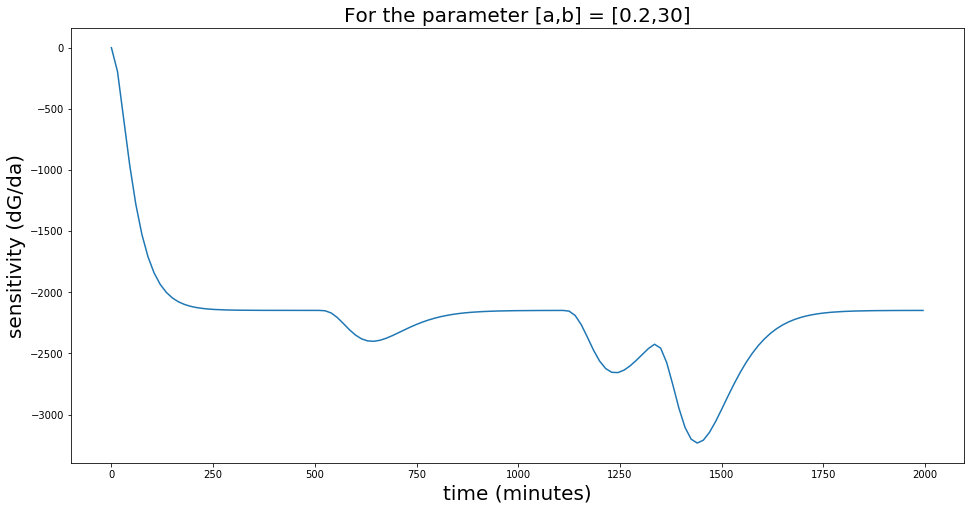

In [6]:
#For plotting sensitivity vs time graph

plt.figure(figsize=(16,8))
plt.plot(sample,sens_dgda)
plt.xlabel('time (minutes)',fontsize=20)
plt.ylabel('sensitivity (dG/da)',fontsize = 20)
plt.title('For the parameter [a,b] = [0.2,30]',fontsize=20)

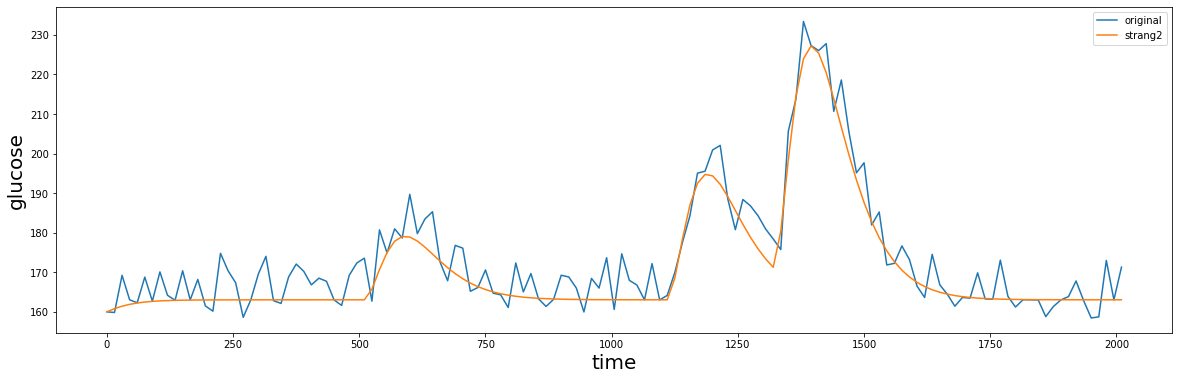

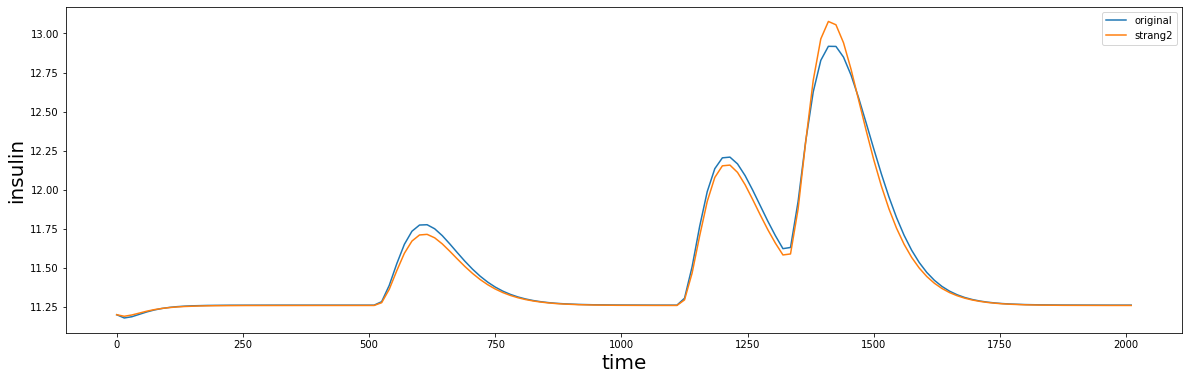

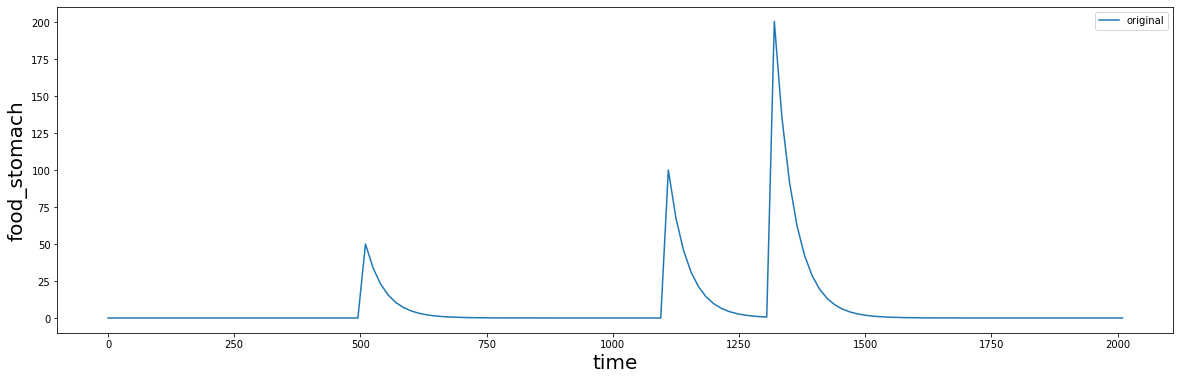

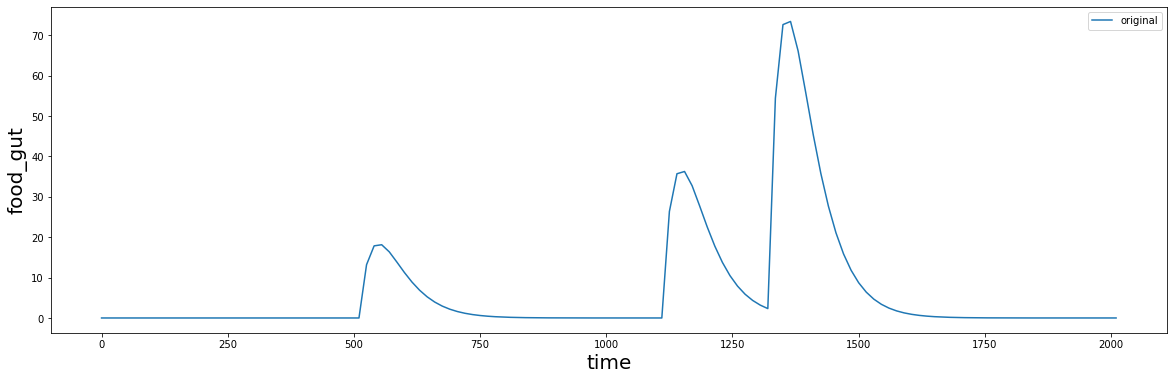

In [9]:
#Function definitions
def odesolve(z0,time,eps,f):
    z=z0
    sol=[]
    for t in time:
        sol.append(z) 
        if t==510:
            z[2] = z[2] + 50
        elif t==1110:
            z[2] = z[2] + 100
        elif t==1320:
            z[2] = z[2] + 200
         
        k1 = eps*f(z,t)
        k2 = eps*f(z+ k1/2, t + eps/2)
        k3 = eps*f(z+ k2/2, t + eps/2)
        k4 = eps*f(z + k3, t + eps)
        z=z + (k1 + 2*k2 + 2*k3 + k4)/6
        
    return sol


def G_I(state,t):
    
    g,i,st,gt= state
    
    
        
    dgdt = R0 - (EG0 + SI*i)*g + Kgut*gt
    didt = Imax*g**2/(alpha + g**2) - KI*i
    dstdt = -Ksto*st
    dgtdt = Ksto*st -Kgut*gt
    
    return np.array([dgdt,didt,dstdt,dgtdt])

def G_I_nn(state,t):
    g,i,st,gt= state
    dgdt = R0 - (EG0 + SI*i)*g + Kgut*gt
    didt = strang2(g,a,b) - KI*i
    
    dstdt = -Ksto*st
    dgtdt = Ksto*st -Kgut*gt
    
    return np.array([dgdt,didt,dstdt,dgtdt])


#G-I model parameters



#for diabetic
if diab=='y':
    R0 = 2.5
    EG0= 2.5*10**-3
    SI=1.14*10**-3
    KI=0.06
    Kgut=0.026
    Ksto=0.026
    alpha=10**4
    Imax=0.93

#for non-diabteic
else:
    R0 = 2.1
    EG0 = 10**-3
    SI = 3.06*10**-3 
    KI = 0.01
    Kgut = 0.098
    Ksto = 0.036
    alpha = 10**4
    Imax = 0.28
        
if diab=='y':
    state= np.array([160,11.2,0,0])
else:
    state= np.array([70,9.2,0,0])

t0=0
t1=2000
eps = 15
t_= np.arange(t0,t1+eps,eps)

x = odesolve(state,t_,eps,G_I)
x = np.array(x)

#adding noise
nois = 17*np.random.random_sample(np.shape(x[:,0])) - 5
idx_ = np.random.randint(len(nois),size=int(len(t_)*0.2))
nois[idx_] = 0
x[:,0] = x[:,0] + nois

xn = odesolve(state,t_,eps,G_I_nn)

g=[]
i=[]
sto=[]
gut=[]
g_=[]
i_=[]
for k in x:
    g.append(k[0])
    i.append(k[1])
    sto.append(k[2])
    gut.append(k[3])
    
for k in xn:
    g_.append(k[0])
    i_.append(k[1])

plt.figure(figsize=(20,6))
plt.plot(t_,g,label='original')
plt.plot(t_,g_,label='strang2')
plt.xlabel('time',fontsize=20)
plt.ylabel('glucose',fontsize=20)
plt.legend()
plt.figure(figsize=(20,6))
plt.plot(t_,i,label='original')
plt.plot(t_,i_,label='strang2')
plt.xlabel('time',fontsize=20)
plt.ylabel('insulin',fontsize=20)
plt.legend()
plt.figure(figsize=(20,6))
plt.plot(t_,sto,label='original')
plt.xlabel('time',fontsize=20)
plt.ylabel('food_stomach',fontsize=20)
plt.legend()
plt.figure(figsize=(20,6))
plt.plot(t_,gut,label='original')
plt.xlabel('time',fontsize=20)
plt.ylabel('food_gut',fontsize=20)
plt.legend()
